In [1]:
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
import argparse
from os import path
import time
import matplotlib.dates as mdates


In [2]:
# load the data
DFSectors = pd.read_csv("NormalisedReturnsSector.csv", index_col = "Date")
DF = pd.read_csv("Companies1992_2012.csv",
                index_col="Date")

In [6]:
# first rows are NaNs because of local renormalisation
print(DF.shape)
DF

(5291, 263)


,AES,LNT,AEP,ATO,CNP,CMS,ED,D,DTE,DUK,...,DVN,EOG,XOM,HAL,HES,MRO,OXY,OKE,SLB,WMB
Date,,,,,,,,,,,,,,,,,,,,,
1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-1.081177,-0.270954,-0.869922,-0.922632,-0.418172,-0.206734,-0.309340,-0.248375,-0.498336,-0.004787,...,-0.958686,-0.813532,-0.403730,-0.682636,-1.422293,-1.156702,-1.287924,-0.178140,-0.243812,-0.919810
2012-12-26,-0.253817,-1.051988,-1.304070,-2.098019,-2.123994,-0.721928,-1.300321,-0.770818,-1.403926,-1.099499,...,-0.725002,-0.962120,0.271965,0.229555,-0.702476,-0.631910,-1.115471,-1.566316,-0.028972,-0.712181
2012-12-27,-1.229936,-0.084106,-0.345997,-0.392188,-0.213158,-0.484121,0.020371,-0.323573,-0.359014,-0.729707,...,-0.085694,-0.109297,-0.185405,-0.427361,-0.168654,-0.355331,-0.165108,-0.301423,0.195096,-1.088528


In [9]:
# compute correlation matrices for overlapping, moving intervals
Period = 40 # 2 trading months
Shift = 1
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],
                         DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))
CorrMatricesFull = np.empty((T,int(DF.shape[1]**2.)))

print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    CorrMatricesFull[t,:] = IntervalCorr
    
    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]

CorrMatrices.shape   

(263, 263)
34453.0
(1, 69169) 34453
1


(5251, 34453)

In [4]:
# Repeated KMeans into 2 clusters

In [10]:
kmean = KMeans(n_clusters = 2,random_state = 12345).fit(CorrMatrices) 


NameError: name 'CorrMatricesSec' is not defined

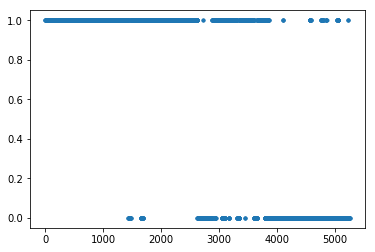

In [11]:
ypred = kmean.predict(CorrMatrices)

plt.plot(ypred,".")

In [12]:
#  now split the initial clusters

CMS0 = CorrMatrices[ypred ==0,:]
CMS1 = CorrMatrices[ypred ==1,:]
print(CMS0.shape,CMS1.shape)

(1839, 34453) (3412, 34453)


In [13]:
kmean0 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS0) 
ypred0 = kmean0.predict(CMS0)

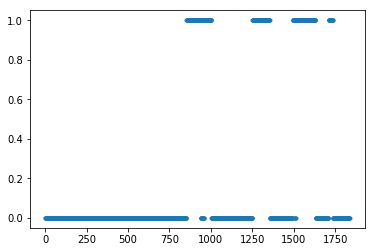

In [14]:
plt.plot(ypred0,".")

In [15]:
#  now split the these sub-clusters
CMS00 = CMS0[ypred0==0,:]
CMS01 = CMS0[ypred0==1,:]
print(CMS00.shape,CMS01.shape)

(1437, 34453) (402, 34453)


In [16]:
kmean00 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS00) 
ypred00 = kmean00.predict(CMS00)

In [17]:
kmean01 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS01) 
ypred01 = kmean01.predict(CMS01)

In [18]:
# final splits for the first initial cluster
CMS000 = CMS00[ypred00==0,:]
CMS001 = CMS00[ypred00==1,:]
CMS010 = CMS01[ypred01==0,:]
CMS011 = CMS01[ypred01==1,:]
print(CMS000.shape,
     CMS001.shape,
     CMS010.shape,
     CMS011.shape)

(745, 34453) (692, 34453) (192, 34453) (210, 34453)


In [19]:
# Now for the second initial cluster

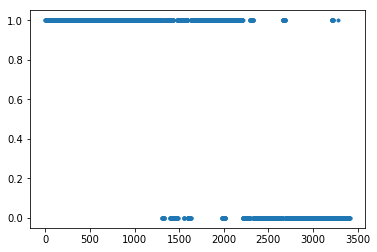

In [20]:
kmean1 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS1) 
ypred1 = kmean1.predict(CMS1)
plt.plot(ypred1,".")

In [21]:
#  now split the these sub-clusters
CMS10 = CMS1[ypred1==0,:]
CMS11 = CMS1[ypred1==1,:]
print(CMS10.shape,CMS11.shape)

(1277, 34453) (2135, 34453)


In [22]:
kmean10 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS10) 
ypred10 = kmean10.predict(CMS10)
kmean11 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS11) 
ypred11 = kmean11.predict(CMS11)

In [23]:
# final splits for the first initial cluster
CMS100 = CMS10[ypred10==0,:]
CMS101 = CMS10[ypred10==1,:]
CMS110 = CMS11[ypred11==0,:]
CMS111 = CMS11[ypred11==1,:]
print(CMS100.shape,
     CMS101.shape,
     CMS10.shape,
     CMS111.shape)

(466, 34453) (811, 34453) (1277, 34453) (1075, 34453)


In [25]:
Labels = np.zeros(CorrMatrices.shape[0])

In [26]:
Lab = Labels[0:10]
print(Lab)
Lab  = np.arange(10)
print(Lab)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9]


In [27]:
print(Labels[0:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
def Label(Instance):
    
    
    Label1 = kmean.predict(Instance.reshape(1, -1))

    if Label1 == 0:
    
        Label2 = kmean0.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean00.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean01.predict(Instance.reshape(1,-1))
    
    
    elif Label1 == 1:
    
        Label2 = kmean1.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean10.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean11.predict(Instance.reshape(1,-1))
    return(str(Label1[0])+str(Label2[0])+str(Label3[0]))
            

In [30]:
Labels = []
for i in range(CorrMatrices.shape[0]):
    Labels.append(Label(CorrMatrices[i,:]))

In [31]:
sum(np.array(Labels)== '101')

811

In [32]:
Labels = np.array(Labels)

Labels[Labels=="000"] = "1"
Labels[Labels=="001"] = "2"
Labels[Labels=="010"] = "3"
Labels[Labels=="011"] = "4"
Labels[Labels=="100"] = "5"
Labels[Labels=="101"] = "6"
Labels[Labels=="110"] = "7"
Labels[Labels=="111"] = "8"


In [38]:
TimeIndex = DF.index[20:(len(DF.index)-20)]

In [39]:
T = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in TimeIndex]

In [40]:
T

[datetime.date(1992, 1, 30),
 datetime.date(1992, 1, 31),
 datetime.date(1992, 2, 3),
 datetime.date(1992, 2, 4),
 datetime.date(1992, 2, 5),
 datetime.date(1992, 2, 6),
 datetime.date(1992, 2, 7),
 datetime.date(1992, 2, 10),
 datetime.date(1992, 2, 11),
 datetime.date(1992, 2, 12),
 datetime.date(1992, 2, 13),
 datetime.date(1992, 2, 14),
 datetime.date(1992, 2, 18),
 datetime.date(1992, 2, 19),
 datetime.date(1992, 2, 20),
 datetime.date(1992, 2, 21),
 datetime.date(1992, 2, 24),
 datetime.date(1992, 2, 25),
 datetime.date(1992, 2, 26),
 datetime.date(1992, 2, 27),
 datetime.date(1992, 2, 28),
 datetime.date(1992, 3, 2),
 datetime.date(1992, 3, 3),
 datetime.date(1992, 3, 4),
 datetime.date(1992, 3, 5),
 datetime.date(1992, 3, 6),
 datetime.date(1992, 3, 9),
 datetime.date(1992, 3, 10),
 datetime.date(1992, 3, 11),
 datetime.date(1992, 3, 12),
 datetime.date(1992, 3, 13),
 datetime.date(1992, 3, 16),
 datetime.date(1992, 3, 17),
 datetime.date(1992, 3, 18),
 datetime.date(1992, 3, 1

In [41]:
print(len(T), len(Labels))

5251 5251


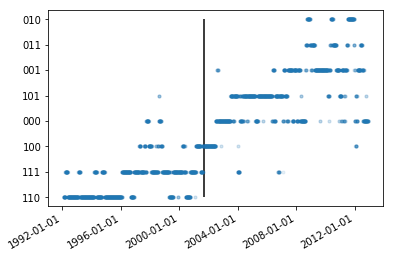

In [47]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,Labels, ".", alpha = 0.1)
plt.vlines(datetime.date(2001,9,11), "110", "010")
plt.gcf().autofmt_xdate()

In [44]:
np.array(np.unique(Labels, return_counts=True)).T

array([['000', '745'],
       ['001', '692'],
       ['010', '192'],
       ['011', '210'],
       ['100', '466'],
       ['101', '811'],
       ['110', '1060'],
       ['111', '1075']], dtype='<U21')

## distance to cluster centres

Let's look at some examples: "001" has the most instances, "010" the least. Maybe this translates to something interesting in the distance-over-time-curve?


In [52]:
Centroid000 = kmean00.cluster_centers_[0]
Distance000 = np.zeros(len(Labels))

Centroid001 = kmean00.cluster_centers_[1]
Distance001 = np.zeros(len(Labels))

Centroid010 = kmean01.cluster_centers_[0]
Distance010 = np.zeros(len(Labels))

Centroid011 = kmean01.cluster_centers_[1]
Distance011 = np.zeros(len(Labels))

Centroid100 = kmean10.cluster_centers_[0]
Distance100 = np.zeros(len(Labels))

Centroid101 = kmean10.cluster_centers_[1]
Distance101 = np.zeros(len(Labels))

Centroid110 = kmean11.cluster_centers_[0]
Distance110 = np.zeros(len(Labels))

Centroid111 = kmean11.cluster_centers_[1]
Distance111 = np.zeros(len(Labels))

for i in range(len(Distance001)):
    Distance000[i] =  np.sum( (Centroid000 - CorrMatrices[i,:])**2.)
    Distance001[i] = np.sum( (Centroid001 - CorrMatrices[i,:])**2.)
    Distance010[i] =  np.sum( (Centroid010 - CorrMatrices[i,:])**2.)
    Distance011[i] =  np.sum( (Centroid011 - CorrMatrices[i,:])**2.)
    Distance100[i] =  np.sum( (Centroid100 - CorrMatrices[i,:])**2.)
    Distance101[i] =  np.sum( (Centroid101 - CorrMatrices[i,:])**2.)
    Distance110[i] =  np.sum( (Centroid110 - CorrMatrices[i,:])**2.)
    Distance111[i] =  np.sum( (Centroid111 - CorrMatrices[i,:])**2.)    
    
    

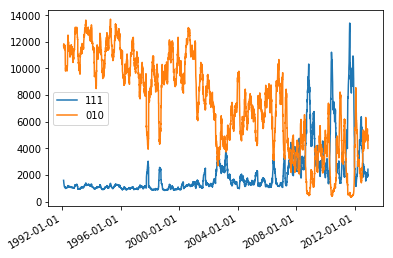

In [54]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
#plt.yscale('log')
plt.plot(T,Distance111, label = "111")
plt.plot(T,Distance010, label="010")
#plt.plot(T,Distance101, label="101")

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

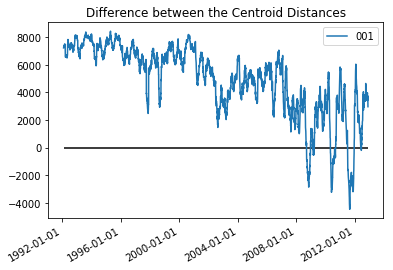

In [57]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,Distance010- Distance001, label = "001")
plt.hlines(0, min(T), max(T))
#plt.plot(T,Distance010, label="010")
#plt.plot(T,Distance101, label="101")
plt.title("Difference between the Centroid Distances")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [58]:
np.corrcoef(Distance001, Distance010)

array([[1.        , 0.85089695],
       [0.85089695, 1.        ]])

There seems to be "something" around ~2001. At this time, the cluster 001 certainly seems to not be able to "tell" what is going on because of the large distance, whereas the small cluster 010 gets very close to the current correlation matrix. As a comparison, one can have a look at two large clusters, e.g. the two largest 001 and 101

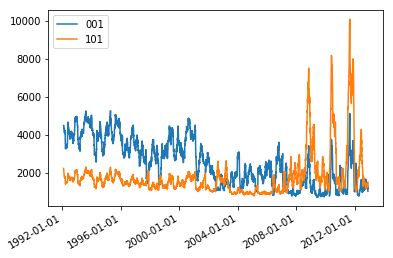

In [59]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
#plt.yscale('log')
plt.plot(T,Distance001, label = "001")
#plt.plot(T,Distance010, label="010")
plt.plot(T,Distance101, label="101")

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

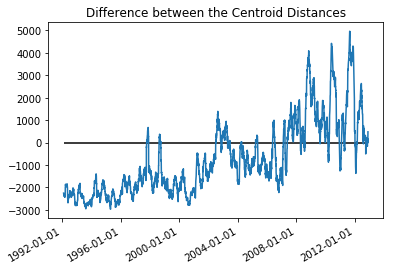

In [60]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,Distance101- Distance001)
plt.hlines(0, min(T), max(T))
plt.title("Difference between the Centroid Distances")

#plt.plot(T,Distance010, label="010")
#plt.plot(T,Distance101, label="101")

plt.gcf().autofmt_xdate()
plt.show()

In [61]:
np.corrcoef(Distance001, Distance101)

array([[1.        , 0.05865007],
       [0.05865007, 1.        ]])

## Machine Learning

Start with a simple One-vs-one-classifier from Aurelien/Geron textbook

In [62]:
print(Labels)

['110' '110' '110' ... '000' '000' '000']


In [63]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
import sklearn
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))


In [65]:
X = CorrMatricesFull.copy()
y = Labels.copy()

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [66]:
print(len(y_test), len(y_train))

1733 3518


In [67]:
ovo_clf.fit(X_train, y_train)


OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [68]:
sum(ovo_clf.predict(X_test) == y_test)/len(y_test)

0.9642238892094633

That's really, really good!

In [69]:
Labels

array(['110', '110', '110', ..., '000', '000', '000'], dtype='<U3')

## Train Neural Net

On CorrMatricesFullSec (full "image-like" square matrix) or on the triangular CorrMatricesSec.
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

https://keras.io/examples/vision/mnist_convnet/

In [70]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU

/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/

In [76]:
# Transform the data to a fitting shape
x = []

for i in range(X.shape[0]):
    x.append(X[i,:].reshape(DF.shape[1],DF.shape[1]))
    
enc = sklearn.preprocessing.OrdinalEncoder()
yNN =     enc.fit_transform(y.reshape(-1,1))

# check
for i in range(4000,4100):
    print(yNN[i], y[i])

[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[1.] 001
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[0.] 000
[5.] 101
[5.] 101
[5.] 101
[0.] 000
[0.] 000
[5.] 101


In [77]:

num_classes = 8
input_shape = (DF.shape[1], DF.shape[1], 1)

# the data, split between train and test sets
x_train,x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, yNN, test_size=0.33, random_state=42)


# images are already scaled to the [0, 1] range

# Make sure images have shape (11, 11, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (3518, 263, 263, 1)
3518 train samples
1733 test samples


In [113]:
layer1 = keras.layers.Dense(units=128, activation=keras.layers.LeakyReLU(alpha=0.05))
layer2 = keras.layers.Dense(units=128, activation=keras.layers.LeakyReLU(alpha=0.01))

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        #layers.Dense(units=128, 
        #      activation=keras.layers.LeakyReLU(alpha=0.05)), 
        # layers.Dense(units=128, 
        #      activation=keras.layers.LeakyReLU(alpha=0.01)), 
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 261, 261, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               33554560  
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

In [114]:
batch_size = 128
epochs = 10

model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(x_train, y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.2)


Train on 2814 samples, validate on 704 samples
Epoch 1/10
2814/2814 [==============================] - 59s 21ms/sample - loss: 1.7021 - acc: 0.3500 - val_loss: 1.0562 - val_acc: 0.6818
Epoch 2/10
2814/2814 [==============================] - 59s 21ms/sample - loss: 1.0619 - acc: 0.6183 - val_loss: 0.6908 - val_acc: 0.8793
Epoch 3/10
2814/2814 [==============================] - 59s 21ms/sample - loss: 0.7084 - acc: 0.7726 - val_loss: 0.3502 - val_acc: 0.9247
Epoch 4/10
2814/2814 [==============================] - 59s 21ms/sample - loss: 0.5019 - acc: 0.8422 - val_loss: 0.2464 - val_acc: 0.9403
Epoch 5/10
2814/2814 [==============================] - 59s 21ms/sample - loss: 0.3376 - acc: 0.8952 - val_loss: 0.1582 - val_acc: 0.9560
Epoch 6/10
2814/2814 [==============================] - 59s 21ms/sample - loss: 0.3034 - acc: 0.9051 - val_loss: 0.1434 - val_acc: 0.9616
Epoch 7/10
2814/2814 [==============================] - 59s 21ms/sample - loss: 0.2437 - acc: 0.9158 - val_loss: 0.1128 - val

In [115]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.09173799476404101
Test accuracy: 0.9705713


A little bit better

In [116]:
model.predict_classes(x_test)

array([0, 0, 0, ..., 7, 5, 1])

In [117]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [118]:
np.argmax(y_test, axis=1)

array([0, 0, 0, ..., 7, 5, 1])

In [119]:
sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1),   # true labels
                                 model.predict_classes(x_test)) # predictions

array([[229,   4,   0,   0,   0,   7,   0,   0],
       [  5, 227,   0,   3,   0,   0,   0,   0],
       [  0,   0,  68,   0,   0,   0,   0,   0],
       [  0,   2,   3,  65,   0,   0,   0,   0],
       [  1,   0,   0,   0, 151,   2,   0,   1],
       [  3,   0,   0,   0,   0, 244,   0,   0],
       [  0,   0,   0,   0,   0,   0, 378,   0],
       [  0,   0,   0,   0,   7,   2,  11, 320]])

In [120]:
model.save("KerasNN_FullFinanceData_Relu")

In [131]:
# save the Data

np.save('x_test.npy', x_test) 
np.save('x_train.npy', x_train)   
np.save('y_test.npy', y_test) 
np.save('y_train.npy', y_train)   


In [133]:
model.save_weights('KerasNN_FullFinanceData_ReLu.h5')

In [132]:
input_shape

(263, 263, 1)